In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
# cluster.scale(24)
# # # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/jul2021/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37238 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:37238/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:37238/status,Workers: 8
Total threads: 56,Total memory: 251.63 GiB
Comm: tcp://127.0.0.1:34581,Workers: 8
Dashboard: http://127.0.0.1:37238/status,Total threads: 56
Started: Just now,Total memory: 251.63 GiB
Comm: tcp://127.0.0.1:46841,Total threads: 7
Dashboard: http://127.0.0.1:41589/status,Memory: 31.45 GiB
Nanny: tcp://127.0.0.1:43654,


In [20]:
client.restart()

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:44450/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:44450/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://127.0.0.1:39933,Workers: 0
Dashboard: http://127.0.0.1:44450/status,Total threads: 0
Started: 2 hours ago,Total memory: 0 B


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          12398524      visu      viz  tuchida  R       6:05      1 n4366
8


In [2]:
import numpy as np
import xarray as xr
import qgutils
from xgcm.grid import Grid
import os.path as op
# import dask_image.ndfilters as ndfilters
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [3]:
ddir = '/store/tuchida/msom/msqg/'
scratch = '/scratch/cnt0024/hmg2840/tuchida/stochas/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
Nh = 512
N = 256/2    # Number of horizontal grids
L0 = 80
H = 5e3
dxh = L0/Nh
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
# ntime = 187

In [8]:
ds_truth = xr.open_dataset(op.join(ddir,'stochas/outdir_0002/vars.nc')
                          ).isel(z=0)   # high-res "truth"
ds_truth = ds_truth.rename({'t':'time','y':'YC','x':'XC'})
ds_truth.coords['time'] = ('time',ds_truth.time.data)
# ds_truth.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds_truth.coords['YG'] = ('YG',Rd*np.arange(0,L0,dxh))
ds_truth.coords['XG'] = ('XG',Rd*np.arange(0,L0,dxh))
ds_truth.coords['YC'] = ('YC',Rd*np.arange(dxh/2,L0+dxh/2,dxh))
ds_truth.coords['XC'] = ('XC',Rd*np.arange(dxh/2,L0+dxh/2,dxh))
# ds_truth.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds_truth.coords['drF'] = ('Z',np.array([.06,.14,.8]))
# ds_truth.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds_truth = ds_truth.chunk({'time':10,'YC':128,'XC':128})
ds_truth

,Array,Chunk
Bytes,4.86 GiB,640.00 kiB
Shape,"(4977, 512, 512)","(10, 128, 128)"
Count,7969 Tasks,7968 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.86 GiB,640.00 kiB
Shape,"(4977, 512, 512)","(10, 128, 128)"
Count,7969 Tasks,7968 Chunks
Type,float32,numpy.ndarray


In [9]:
ds_nostoch = xr.open_dataset(op.join(ddir,'no-stoch_N128/outdir_0006/vars.nc')
                            ).isel(z=0)   # no stochastic forcing
ds_nostoch = ds_nostoch.rename({'t':'time','y':'YC','x':'XC'})
ds_nostoch.coords['time'] = ('time',ds_nostoch.time.data)
# ds_nostoch.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds_nostoch.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds_nostoch.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds_nostoch.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds_nostoch.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds_nostoch.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds_nostoch.coords['drF'] = ('Z',np.array([.06,.14,.8]))
# ds_nostoch.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds_nostoch = ds_nostoch.chunk({'time':10,'YC':128,'XC':128})
ds_nostoch

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, time: 4977)
Coordinates:
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
    z        float32 0.0
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
  * XG       (XG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
Data variables:
    p        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>
    q        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>

In [10]:
# ds = xr.open_dataset(op.join(ddir,'outdir_0002/vars.nc')) # full model
# ds = xr.open_dataset(op.join(ddir,'outdir_0003/vars.nc'))
# ds = xr.open_dataset(op.join(ddir,'outdir_0004/vars.nc'))
# ds = xr.open_dataset(op.join(ddir,'outdir_0009/vars.nc'))
ds = xr.open_dataset(op.join(ddir,'stochas/outdir_0049/vars.nc')
                    ).isel(z=0)
ds = ds.rename({'t':'time','y':'YC','x':'XC'})
ds.coords['time'] = ('time',ds.time.data)
# ds.coords['Z'] = ('Z',np.array([.03,.13,.6]))
ds.coords['YG'] = ('YG',np.arange(0,L0,dx))
ds.coords['XG'] = ('XG',np.arange(0,L0,dx))
ds.coords['YC'] = ('YC',np.arange(dx/2,L0+dx/2,dx))
ds.coords['XC'] = ('XC',np.arange(dx/2,L0+dx/2,dx))
# ds.coords['Zp1'] = ('Zp1',np.array([0.,.06,.2,1.]))
# ds.coords['drF'] = ('Z',np.array([.06,.14,.8]))
# ds.coords['drC'] = ('Zp1',np.array([.03,.1,.47,.4]))
ds = ds.chunk({'time':10,'YC':128,'XC':128})
ds

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, time: 4977)
Coordinates:
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
    z        float32 0.0
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
  * XG       (XG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
Data variables:
    p        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>
    q        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>

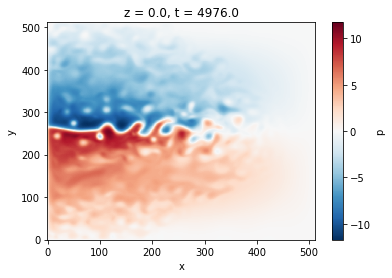

In [11]:
xr.open_dataset(op.join(ddir,'outdir_0002/vars.nc')).p.isel(t=-1,z=0).plot()

In [10]:
print(1000*86400/5e5)

172.8


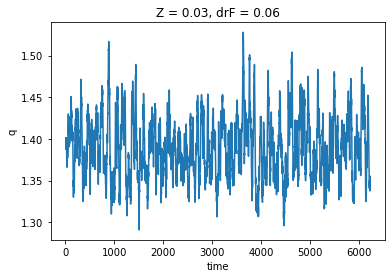

In [40]:
fig, ax = plt.subplots()
np.abs(ds.q.isel(time=slice(10,None),Z=0)).mean(['YC','XC']).plot(ax=ax)
# ax.set_yscale('log')

In [11]:
dsb_truth = ds_truth.mean('time')
dsp_truth = ds_truth - dsb_truth
dsp_truth

,Array,Chunk
Bytes,4.86 GiB,640.00 kiB
Shape,"(4977, 512, 512)","(10, 128, 128)"
Count,26609 Tasks,7968 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,4.86 GiB,640.00 kiB
Shape,"(4977, 512, 512)","(10, 128, 128)"
Count,26609 Tasks,7968 Chunks
Type,float32,numpy.ndarray


In [12]:
dsb = ds_nostoch.isel(time=slice(None,None)).mean('time')
dsp = ds_nostoch.isel(time=slice(None,None)) - dsb
dsp

<xarray.Dataset>
Dimensions:  (XC: 128, XG: 128, YC: 128, YG: 128, time: 4977)
Coordinates:
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
    z        float32 0.0
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * YG       (YG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
  * XG       (XG) float64 0.0 0.625 1.25 1.875 2.5 ... 77.5 78.12 78.75 79.38
Data variables:
    p        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>
    q        (time, YC, XC) float32 dask.array<chunksize=(10, 128, 128), meta=np.ndarray>

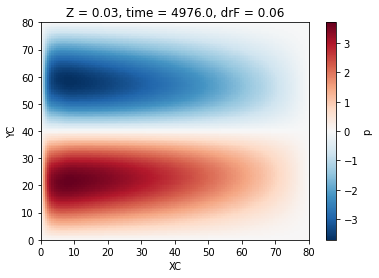

In [38]:
ds_nostoch.p.isel(time=-1,Z=0).plot()

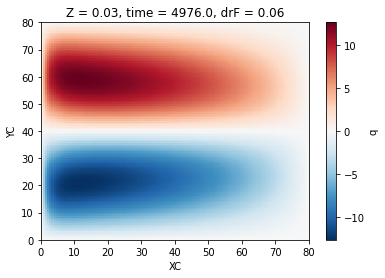

In [39]:
ds_nostoch.q.isel(time=-1,Z=0).plot()

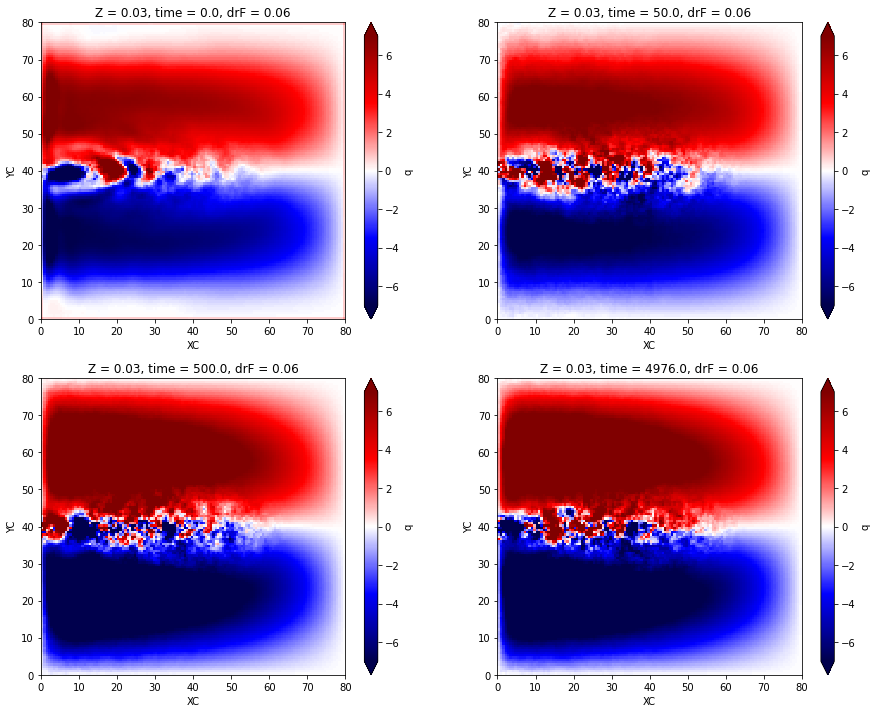

In [10]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
ds.q.isel(time=0,Z=0).plot(ax=axes[0,0], vmax=7, cmap='seismic')
ds.q.isel(time=50,Z=0).plot(ax=axes[0,1], vmax=7, cmap='seismic')
ds.q.isel(time=500,Z=0).plot(ax=axes[1,0], vmax=7, cmap='seismic')
ds.q.isel(time=-1,Z=0).plot(ax=axes[1,1], vmax=7, cmap='seismic')

In [11]:
jacpp = xr.zeros_like(ds.p).load()
for tt in jacpp.time:
    jacpp.sel(time=tt)[:] = qgutils.jacobian(ds.p.sel(time=tt), ds.q.sel(time=tt), Delta=dx)

In [12]:
dsave = jacpp.drop_vars('drF').chunk(ds.p.chunks).to_dataset(name='jacpp')
print(dsave)
dsave.to_zarr(op.join(ddir,'stochas/outdir_0049/JacPsipQp0000/'), mode='w')

<xarray.Dataset>
Dimensions:  (XC: 128, YC: 128, Z: 3, time: 4977)
Coordinates:
  * YC       (YC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * XC       (XC) float64 0.3125 0.9375 1.562 2.188 ... 77.81 78.44 79.06 79.69
  * Z        (Z) float64 0.03 0.13 0.6
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
Data variables:
    jacpp    (time, Z, YC, XC) float32 dask.array<chunksize=(10, 3, 128, 128), meta=np.ndarray>


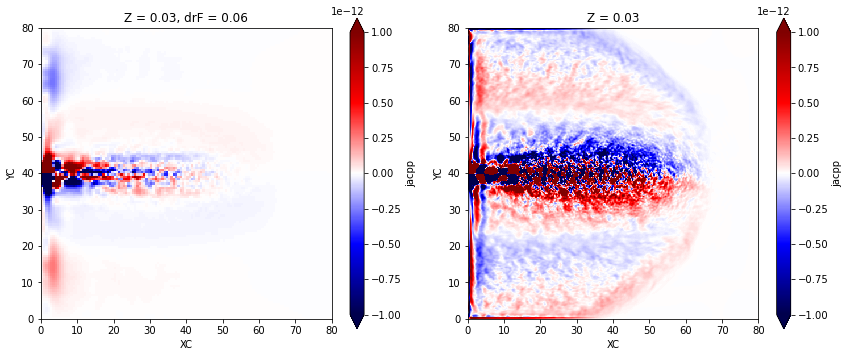

In [47]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
(jacpp.isel(Z=0) * U**2/Rd**2).mean('time').rename('jacpp').plot(ax=ax1, vmax=1e-12, cmap='seismic')
(xr.open_zarr(op.join(ddir,'stochas/JacPsipQp0002/')).jacpp.isel(Z=0) * U**2/Rd**2).mean('time').plot(ax=ax2, vmax=1e-12, cmap='seismic')
ax1.set_aspect('equal', adjustable='box')
ax2.set_aspect('equal', adjustable='box')

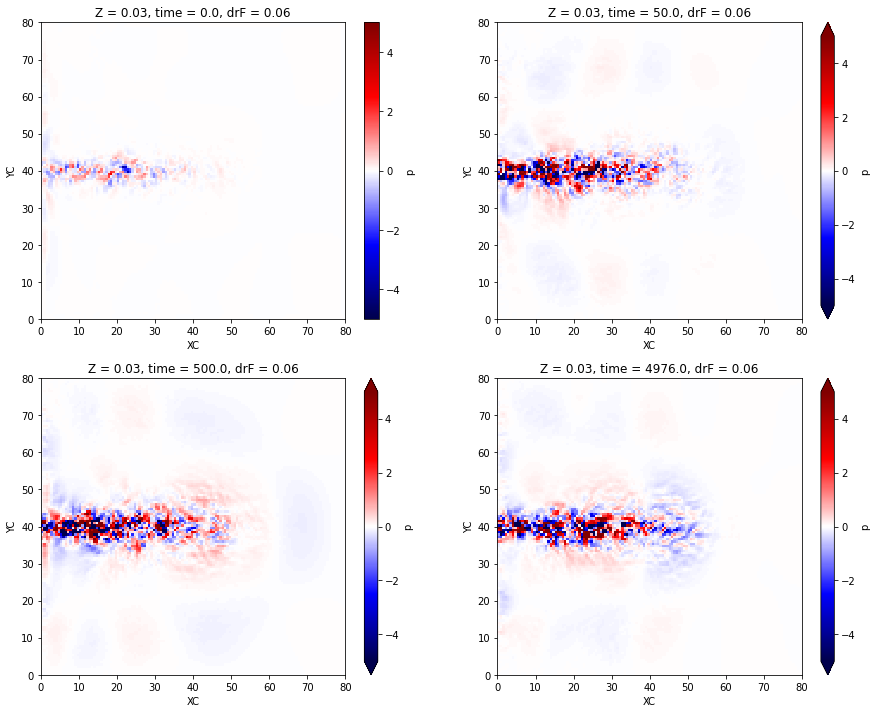

In [17]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
jacpp.isel(time=0,Z=0).plot(ax=axes[0,0], vmax=5, cmap='seismic')
jacpp.isel(time=50,Z=0).plot(ax=axes[0,1], vmax=5, cmap='seismic')
jacpp.isel(time=500,Z=0).plot(ax=axes[1,0], vmax=5, cmap='seismic')
jacpp.isel(time=-1,Z=0).plot(ax=axes[1,1], vmax=5, cmap='seismic')

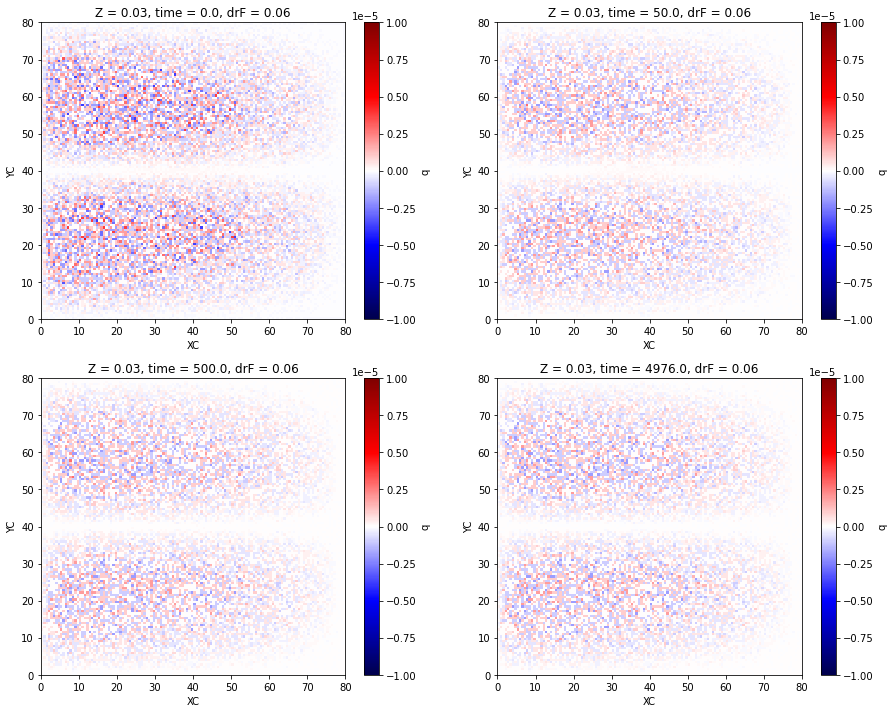

In [54]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
dsp.q.isel(time=0,Z=0).plot(ax=axes[0,0], vmax=1e-5, cmap='seismic')
dsp.q.isel(time=50,Z=0).plot(ax=axes[0,1], vmax=1e-5, cmap='seismic')
dsp.q.isel(time=500,Z=0).plot(ax=axes[1,0], vmax=1e-5, cmap='seismic')
dsp.q.isel(time=-1,Z=0).plot(ax=axes[1,1], vmax=1e-5, cmap='seismic')

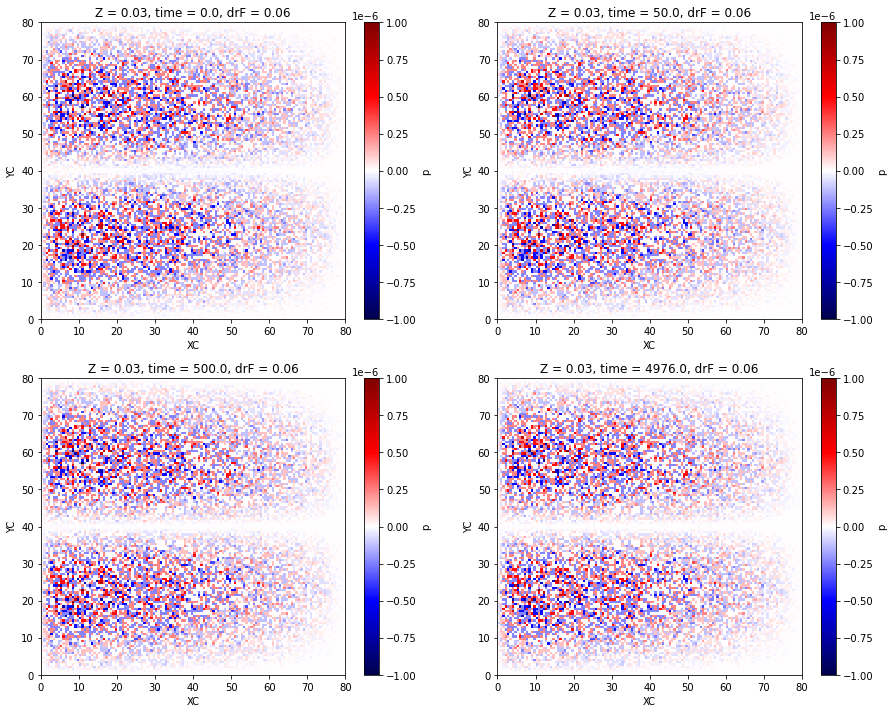

In [24]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
dsp.p.isel(time=0,Z=0).plot(ax=axes[0,0], vmax=1e-6, cmap='seismic')
dsp.p.isel(time=50,Z=0).plot(ax=axes[0,1], vmax=1e-6, cmap='seismic')
dsp.p.isel(time=500,Z=0).plot(ax=axes[1,0], vmax=1e-6, cmap='seismic')
dsp.p.isel(time=-1,Z=0).plot(ax=axes[1,1], vmax=1e-6, cmap='seismic')

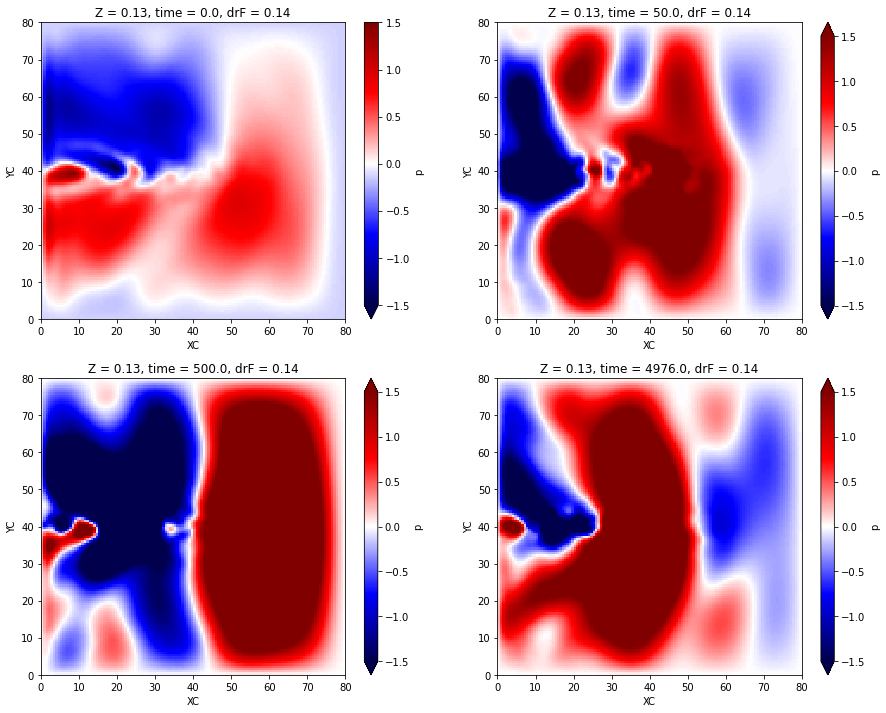

In [19]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
ds.p.isel(time=0,Z=1).plot(ax=axes[0,0], vmax=1.5, cmap='seismic')
ds.p.isel(time=50,Z=1).plot(ax=axes[0,1], vmax=1.5, cmap='seismic')
ds.p.isel(time=500,Z=1).plot(ax=axes[1,0], vmax=1.5, cmap='seismic')
ds.p.isel(time=-1,Z=1).plot(ax=axes[1,1], vmax=1.5, cmap='seismic')

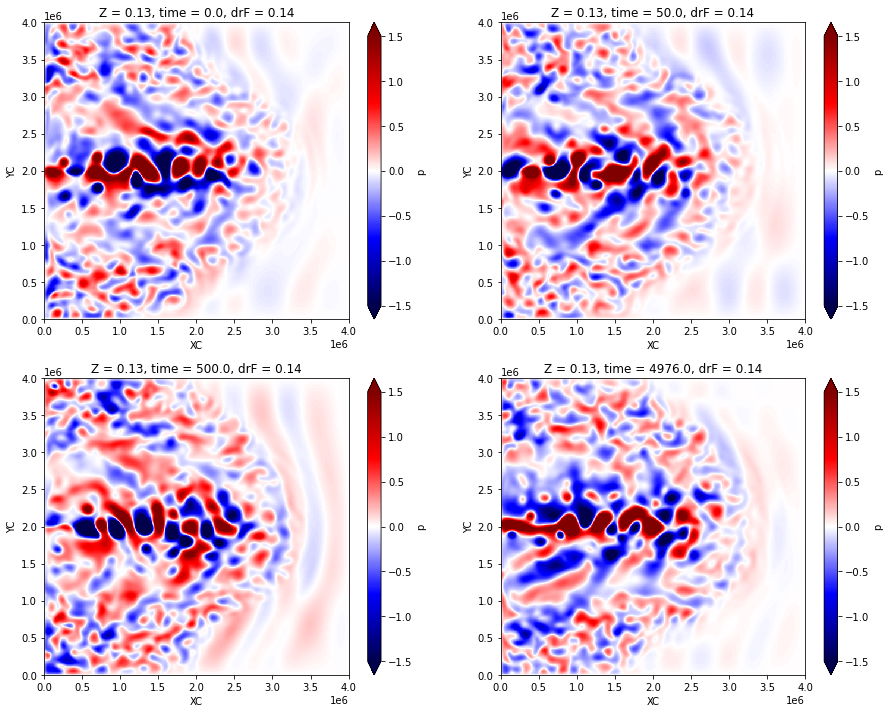

In [40]:
fig, axes = plt.subplots(figsize=(15,12), nrows=2, ncols=2)
dsp_truth.p.isel(time=0,Z=1).plot(ax=axes[0,0], vmax=1.5, cmap='seismic')
dsp_truth.p.isel(time=50,Z=1).plot(ax=axes[0,1], vmax=1.5, cmap='seismic')
dsp_truth.p.isel(time=500,Z=1).plot(ax=axes[1,0], vmax=1.5, cmap='seismic')
dsp_truth.p.isel(time=-1,Z=1).plot(ax=axes[1,1], vmax=1.5, cmap='seismic')

In [13]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi)
    elif nd == 4:
        psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
    elif nd == 5:
        psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

    if (bc == 'dirichlet'): 
        psi[...,0,:]  = -psi[...,1,:]
        psi[...,-1,:] = -psi[...,-2,:]
        psi[...,:,0]  = -psi[...,:,1]
        psi[...,:,-1] = -psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
        psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
        psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
        psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

    elif (bc == 'neumann'): 
        psi[...,0,:]  = psi[...,1,:]
        psi[...,-1,:] = psi[...,-2,:]
        psi[...,:,0]  = psi[...,:,1]
        psi[...,:,-1] = psi[...,:,-2]
    
        # corners
        psi[...,0,0]   = psi[...,1,1]
        psi[...,-1,0]  = psi[...,-2,1]
        psi[...,0,-1]  = psi[...,1,-2]
        psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

In [14]:
psi_padded = xr.DataArray(pad_bc(ds.p.values), 
                          dims=['time','Yp1','Xp1'],
                          coords={'time':ds.time.data,
#                                   'Z':ds.Z.data,
                                  'Yp1':np.arange(-dx/2,L0+dx,dx),
                                  'Xp1':np.arange(-dx/2,L0+dx,dx)}
                         ).chunk({'time':100,'Yp1':65,'Xp1':65})

psi_padded

<xarray.DataArray (time: 4977, Yp1: 130, Xp1: 130)>
dask.array<xarray-<this-array>, shape=(4977, 130, 130), dtype=float32, chunksize=(100, 65, 65), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float32 0.0 1.0 2.0 3.0 ... 4.974e+03 4.975e+03 4.976e+03
  * Yp1      (Yp1) float64 -0.3125 0.3125 0.9375 1.562 ... 79.06 79.69 80.31
  * Xp1      (Xp1) float64 -0.3125 0.3125 0.9375 1.562 ... 79.06 79.69 80.31

In [15]:
u = -psi_padded.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
v = psi_padded.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
EKE = .25*xr.DataArray(  (u**2).isel(Yp1=slice(None,-1)).data 
                      + (u**2).isel(Yp1=slice(1,None)).data 
                      + (v**2).isel(Xp1=slice(None,-1)).data 
                      + (v**2).isel(Xp1=slice(1,None)).data,
                      dims=['time','YC','XC'], 
                      coords={'time':ds.time.data,
#                               'Z':ds.Z.data,
                              'YC':ds.YC.data,'XC':ds.XC.data}
                     )
EKE

,Array,Chunk
Bytes,311.06 MiB,1.51 MiB
Shape,"(4977, 128, 128)","(100, 63, 63)"
Count,15500 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [17]:
psip_padded_nostoch = xr.DataArray(pad_bc(dsp.p.values), 
                                  dims=['time','Yp1','Xp1'],
                                  coords={'time':dsp.time.data,
#                                           'Z':dsp.Z.data,
                                          'Yp1':np.arange(-dx/2,L0+dx,dx),
                                          'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                 ).chunk({'time':100,'Yp1':65,'Xp1':65})
psi_padded_nostoch = xr.DataArray(pad_bc(ds_nostoch.p.values), 
                                  dims=['time','Yp1','Xp1'],
                                  coords={'time':ds_nostoch.time.data,
#                                           'Z':ds_nostoch.Z.data,
                                          'Yp1':np.arange(-dx/2,L0+dx,dx),
                                          'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                 ).chunk({'time':100,'Yp1':65,'Xp1':65})

In [18]:
u_nostoch = -psip_padded_nostoch.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
v_nostoch = psip_padded_nostoch.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
EKE_nostoch = .25*xr.DataArray(  (u_nostoch**2).isel(Yp1=slice(None,-1)).data 
                      + (u_nostoch**2).isel(Yp1=slice(1,None)).data 
                      + (v_nostoch**2).isel(Xp1=slice(None,-1)).data 
                      + (v_nostoch**2).isel(Xp1=slice(1,None)).data,
                      dims=['time','YC','XC'], 
                      coords={'time':dsp.time.data,
#                               'Z':ds.Z.data,
                              'YC':ds.YC.data,'XC':ds.XC.data}
                     )
EKE_nostoch

,Array,Chunk
Bytes,311.06 MiB,1.51 MiB
Shape,"(4977, 128, 128)","(100, 63, 63)"
Count,15500 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [24]:
u_nostoch = -psi_padded_nostoch.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
v_nostoch = psi_padded_nostoch.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
KE_nostoch = .25*xr.DataArray(  (u_nostoch**2).isel(Yp1=slice(None,-1)).data 
                      + (u_nostoch**2).isel(Yp1=slice(1,None)).data 
                      + (v_nostoch**2).isel(Xp1=slice(None,-1)).data 
                      + (v_nostoch**2).isel(Xp1=slice(1,None)).data,
                      dims=['time','YC','XC'], 
                      coords={'time':ds_nostoch.time.data,
#                               'Z':ds.Z.data,
                              'YC':ds.YC.data,'XC':ds.XC.data}
                     )
KE_nostoch

,Array,Chunk
Bytes,311.06 MiB,1.51 MiB
Shape,"(4977, 128, 128)","(100, 63, 63)"
Count,15500 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [19]:
psip_padded_truth = xr.DataArray(pad_bc(dsp_truth.p.values), 
                                  dims=['time','Yp1','Xp1'],
                                  coords={'time':dsp_truth.time.data,
#                                           'Z':dsp_truth.Z.data,
                                          'Yp1':np.arange(-dxh/2,L0+dxh,dxh),
                                          'Xp1':np.arange(-dxh/2,L0+dxh,dxh)}
                                 ).chunk({'time':100,'Yp1':130,'Xp1':130})

u_truth = -psip_padded_truth.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
v_truth = psip_padded_truth.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
EKE_truth = .25*xr.DataArray(  (u_truth**2).isel(Yp1=slice(None,-1)).data 
                      + (u_truth**2).isel(Yp1=slice(1,None)).data 
                      + (v_truth**2).isel(Xp1=slice(None,-1)).data 
                      + (v_truth**2).isel(Xp1=slice(1,None)).data,
                      dims=['time','YC','XC'], 
                      coords={'time':dsp_truth.time.data,
#                               'Z':ds.Z.data,
                              'YC':dsp_truth.YC.data,'XC':dsp_truth.XC.data}
                     )
EKE_truth

,Array,Chunk
Bytes,4.86 GiB,6.25 MiB
Shape,"(4977, 512, 512)","(100, 128, 128)"
Count,84800 Tasks,5000 Chunks
Type,float32,numpy.ndarray


In [19]:
vort = laplacian(psi_padded, Delta=dx, padded=True, 
                 dim=['time','Z','Yp1','Xp1'], chunks={'Yp1':65,'Xp1':65}
                )
vort

,Array,Chunk
Bytes,791.44 MiB,4.54 MiB
Shape,"(4221, 3, 128, 128)","(100, 3, 63, 63)"
Count,10664 Tasks,688 Chunks
Type,float32,numpy.ndarray


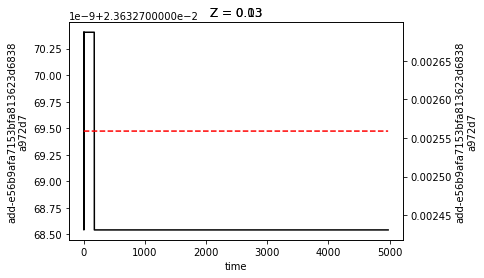

In [50]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
KE_nostoch.isel(Z=0).mean(['YC','XC']).plot(ax=ax, c='k')
KE_nostoch.isel(Z=1).mean(['YC','XC']).plot(ax=ax2, c='r', ls='--')

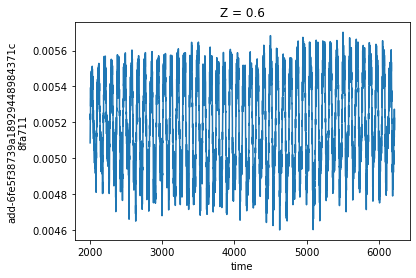

In [21]:
KE.isel(Z=2).mean(['YC','XC']).plot()

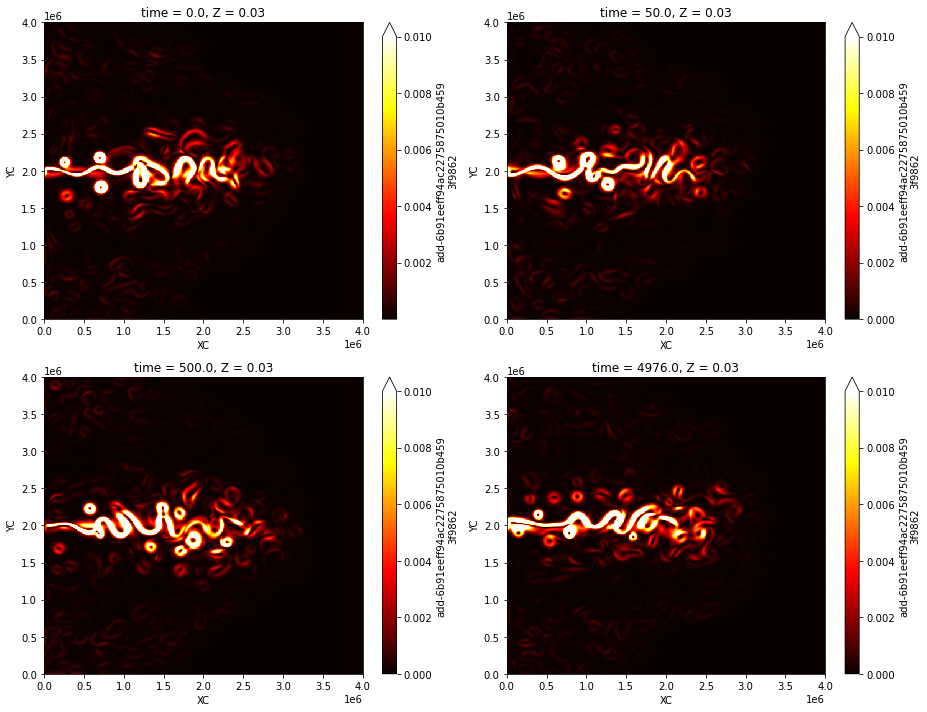

In [19]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(EKE_truth.isel(Z=0)*U**2).isel(time=0).plot(ax=axes[0,0], vmax=.01, cmap='hot')
(EKE_truth.isel(Z=0)*U**2).isel(time=50).plot(ax=axes[0,1], vmax=.01, cmap='hot')
(EKE_truth.isel(Z=0)*U**2).isel(time=500).plot(ax=axes[1,0], vmax=.01, cmap='hot')
(EKE_truth.isel(Z=0)*U**2).isel(time=-1).plot(ax=axes[1,1], vmax=.01, cmap='hot')

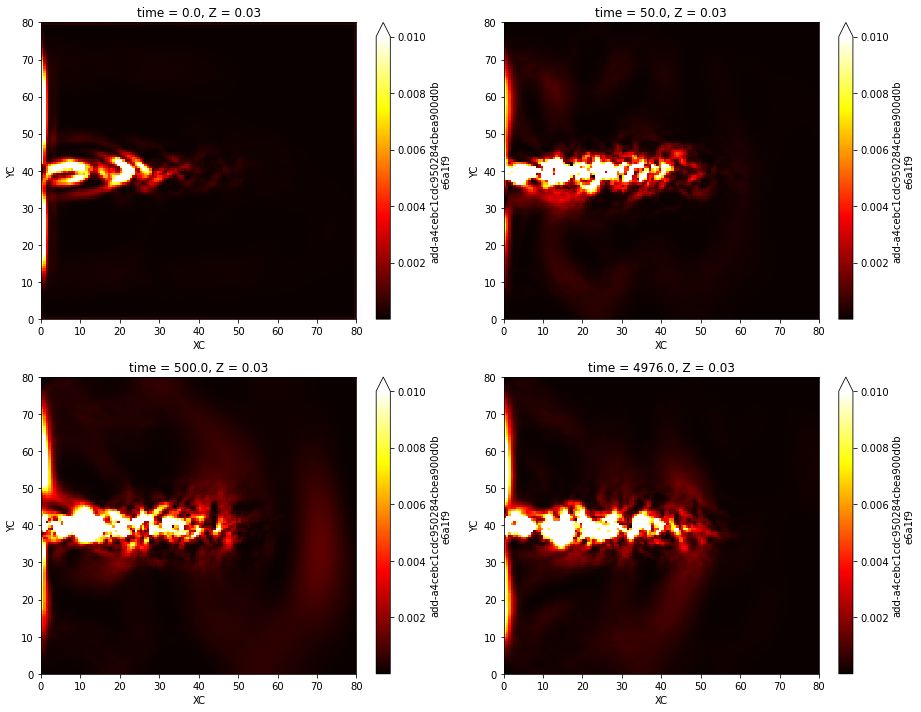

In [41]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(EKE.isel(Z=0)*U**2).isel(time=0).plot(ax=axes[0,0], vmax=.01, cmap='hot')
(EKE.isel(Z=0)*U**2).isel(time=50).plot(ax=axes[0,1], vmax=.01, cmap='hot')
(EKE.isel(Z=0)*U**2).isel(time=500).plot(ax=axes[1,0], vmax=.01, cmap='hot')
(EKE.isel(Z=0)*U**2).isel(time=-1).plot(ax=axes[1,1], vmax=.01, cmap='hot')

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

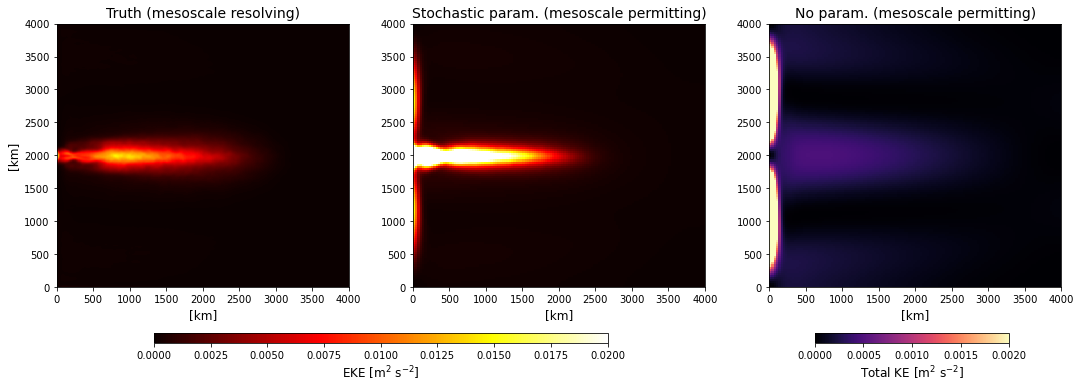

In [27]:
fig, axes = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
# fig.set_tight_layout(True)
im = axes[0].pcolormesh(EKE_truth.XC*1e-3, EKE_truth.YC*1e-3, 
                        (EKE_truth*U**2).mean('time',skipna=True), 
                        vmin=0., vmax=.02, cmap='hot', rasterized=True)
axes[1].pcolormesh(EKE.XC*Rd*1e-3, EKE.YC*Rd*1e-3, 
                   (EKE*U**2).mean('time',skipna=True), 
                   vmin=0., vmax=.02, cmap='hot', rasterized=True)
im2 = axes[2].pcolormesh(KE_nostoch.XC*Rd*1e-3, KE_nostoch.YC*Rd*1e-3, 
                         (KE_nostoch*U**2).mean('time',skipna=True), 
                         vmin=0., vmax=2e-3, cmap='magma', rasterized=True)

axes[0].set_title(r"Truth (mesoscale resolving)", fontsize=14)
axes[1].set_title(r"Stochastic param. (mesoscale permitting)", fontsize=14)
axes[2].set_title(r"No param. (mesoscale permitting)", fontsize=14)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)
axes[2].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(bottom=0.27, wspace=.22)
cbaxes1 = fig.add_axes([0.2, 0.14, 0.35, 0.024]) 
cbar1 = fig.colorbar(im, orientation='horizontal', cax=cbaxes1)
cbar1.set_label(r"EKE [m$^2$ s$^{-2}$]", fontsize=12)
cbaxes2 = fig.add_axes([0.71, 0.14, 0.15, 0.024]) 
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbaxes2)
cbar2.set_label(r"Total KE [m$^2$ s$^{-2}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/EKE_cmp.pdf'))

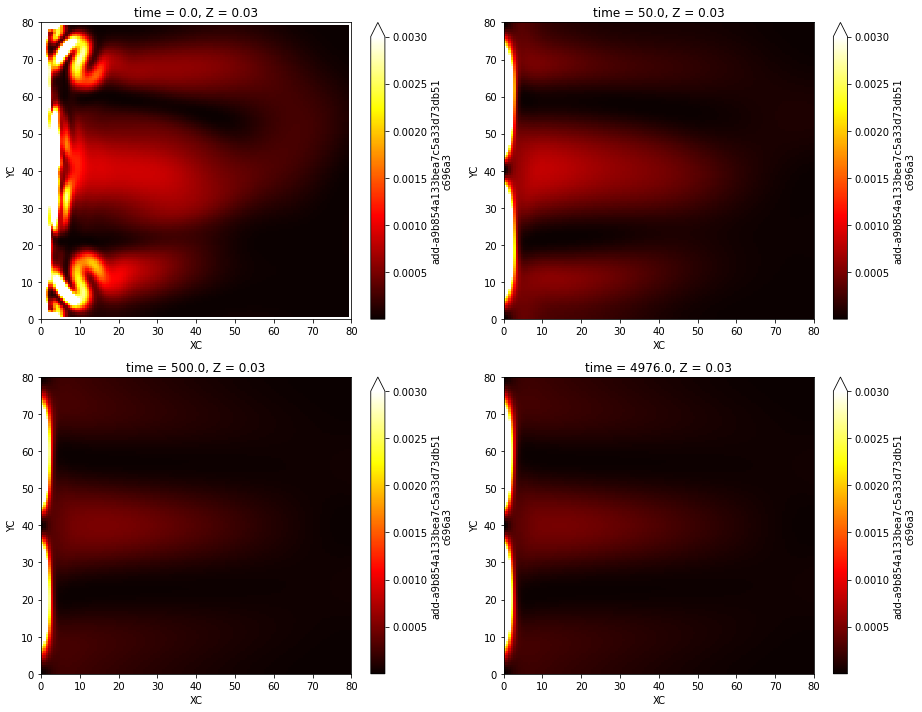

In [19]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(KE_nostoch.isel(Z=0)*U**2).isel(time=0).plot(ax=axes[0,0], vmax=.003, cmap='hot')
(KE_nostoch.isel(Z=0)*U**2).isel(time=50).plot(ax=axes[0,1], vmax=.003, cmap='hot')
(KE_nostoch.isel(Z=0)*U**2).isel(time=500).plot(ax=axes[1,0], vmax=.003, cmap='hot')
(KE_nostoch.isel(Z=0)*U**2).isel(time=-1).plot(ax=axes[1,1], vmax=.003, cmap='hot')

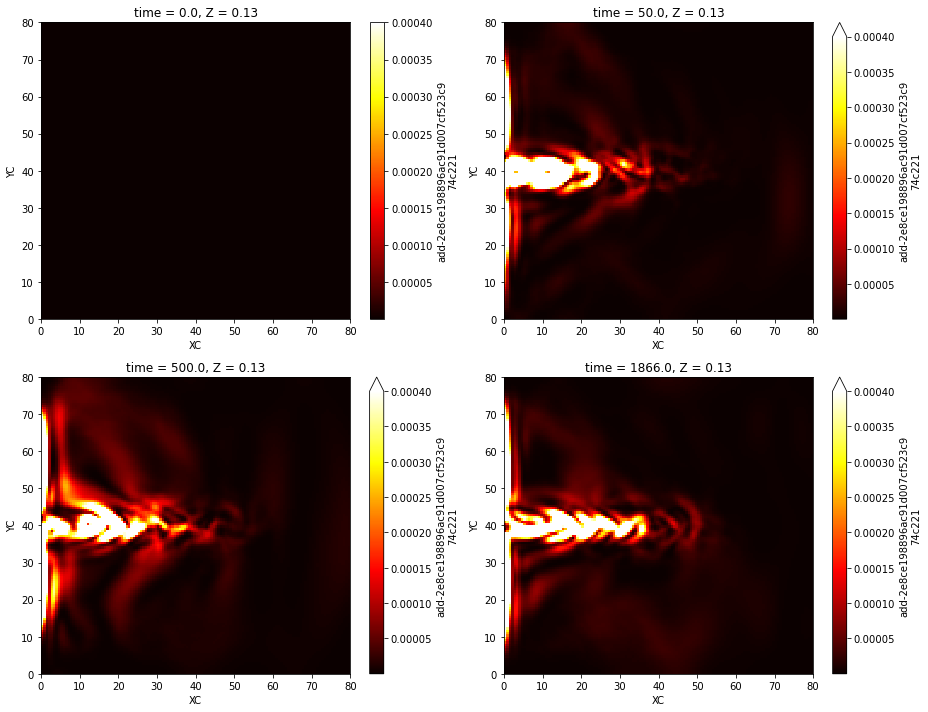

In [51]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(KE.isel(Z=1)*U**2).isel(time=0).plot(ax=axes[0,0], vmax=.0004, cmap='hot')
(KE.isel(Z=1)*U**2).isel(time=50).plot(ax=axes[0,1], vmax=.0004, cmap='hot')
(KE.isel(Z=1)*U**2).isel(time=500).plot(ax=axes[1,0], vmax=.0004, cmap='hot')
(KE.isel(Z=1)*U**2).isel(time=-1).plot(ax=axes[1,1], vmax=.0004, cmap='hot')

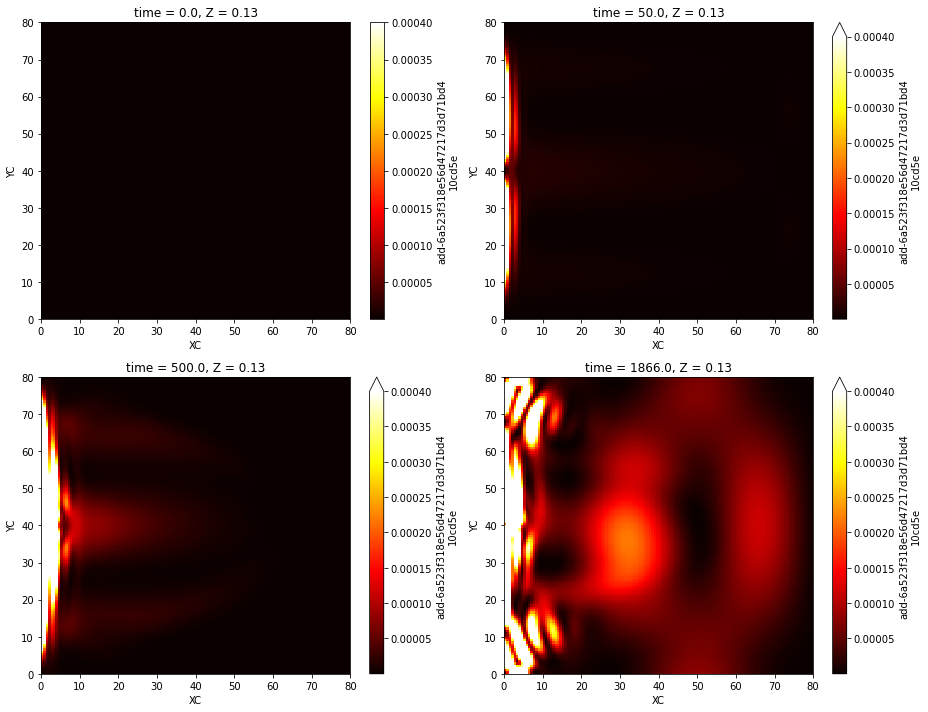

In [52]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(KE_nostoch.isel(Z=1)*U**2).isel(time=0).plot(ax=axes[0,0], vmax=.0004, cmap='hot')
(KE_nostoch.isel(Z=1)*U**2).isel(time=50).plot(ax=axes[0,1], vmax=.0004, cmap='hot')
(KE_nostoch.isel(Z=1)*U**2).isel(time=500).plot(ax=axes[1,0], vmax=.0004, cmap='hot')
(KE_nostoch.isel(Z=1)*U**2).isel(time=-1).plot(ax=axes[1,1], vmax=.0004, cmap='hot')

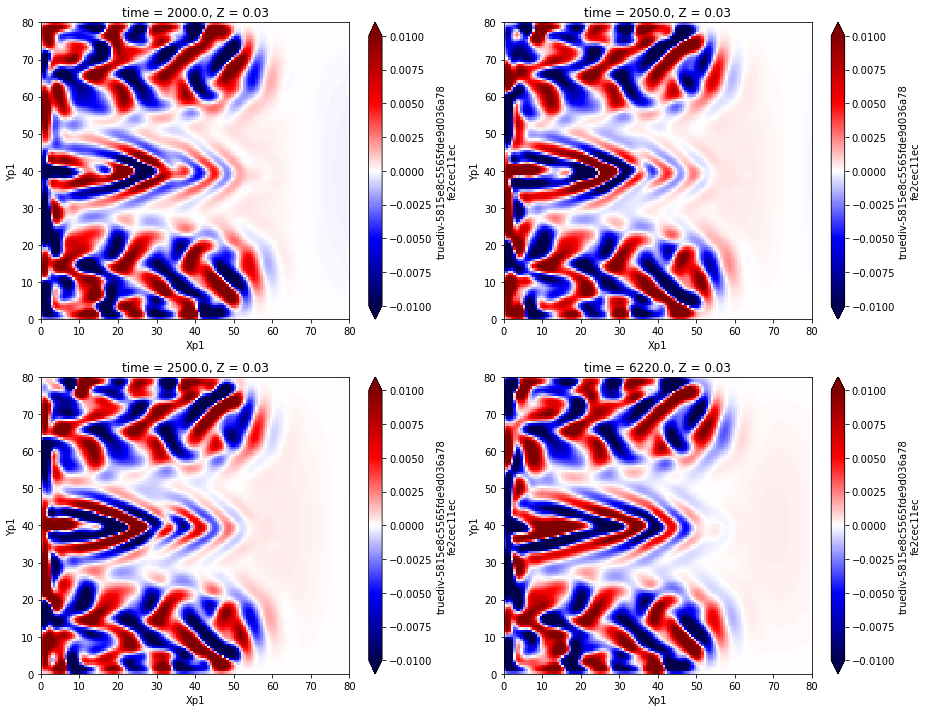

In [24]:
fig, axes = plt.subplots(figsize=(13,10), nrows=2, ncols=2)
fig.set_tight_layout(True)
(vort.isel(Z=0)*Rom).isel(time=0).plot(ax=axes[0,0], vmax=.01, cmap='seismic')
(vort.isel(Z=0)*Rom).isel(time=50).plot(ax=axes[0,1], vmax=.01, cmap='seismic')
(vort.isel(Z=0)*Rom).isel(time=500).plot(ax=axes[1,0], vmax=.01, cmap='seismic')
(vort.isel(Z=0)*Rom).isel(time=-1).plot(ax=axes[1,1], vmax=.01, cmap='seismic')

In [ ]:
psipN = xr.zeros_like(ds.p.isel(Z=0)[::10]).copy().load()
xi = xr.open_dataset(op.join(scratch,'jacstd_N128-from-N512_nl3.nc')).xi

for tt in range(len(ds.time[::10])):
    for j in range(len(ds.YC)):
        for i in range(len(ds.XC)):
            psipN[tt,j,i] = (ds.p.isel(Z=0,YC=j,XC=i)[::10][tt]*np.random.normal(scale=.5*xi.isel(Z=0,Yp1=j,Xp1=i)))

psipN

distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [ ]:
psipN.to_dataset(name='N').to_zarr(op.join(ddir,'stochas/psipN_05xi_Z0_N128/'), mode='w')

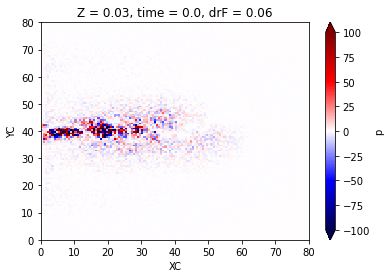

In [15]:
(ds.p.isel(time=0,Z=0)*noise).plot(vmax=100, cmap='seismic')

In [20]:
client.close()